# Report 29.11.2021


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import glob
import os

import sys
sys.path.append('../src/')


import traj_descriptors
from functools import reduce

In [2]:
def calculate_metrix(Data,file_prefix):
    Group_Traj=Data.groupby('particle')
    df1=Group_Traj.apply(traj_descriptors.total_displacement).reset_index(name='TOTAL_DIST')
    df2=Group_Traj.apply(traj_descriptors.end_to_end_displacement).reset_index(name='END_TO_END')
    df3=Group_Traj.apply(traj_descriptors.persistence).reset_index(name='PERSISTENCE')
    Med_Speed=Group_Traj.apply(traj_descriptors.med_speed).reset_index(name='MED_SPEED')
    df4=Group_Traj.apply(traj_descriptors.MSD).reset_index(name='MSD')
    df5=Group_Traj.apply(traj_descriptors.max_distance_origin).reset_index(name='MAX_DIST_ORIG')
    df6=Group_Traj.apply(len).reset_index(name='TRAJ_LEN')
    df7=Group_Traj['area'].apply(np.median).reset_index(name='MEDIAN_AREA')
    df8=Group_Traj['area'].apply(np.max).reset_index(name='MAX_AREA')
    df9=Group_Traj['major_axis_length'].apply(np.median).reset_index(name='MEDIAN_MAJOR_AXIS')
    Translational_exponent=Group_Traj.apply(traj_descriptors.traj_translational_exponent)
    Global_angle=Group_Traj.apply(traj_descriptors.global_angle).reset_index(name='GLOBAL_ANGLE')
    Relative_angle=Group_Traj.apply(traj_descriptors.relative_angle).reset_index(name='RELATIVE_ANGLE')

    df=[df1,df2,df3,df4,Med_Speed,df5,df6,df7,df9,Translational_exponent,Global_angle,Relative_angle]
    TrajDescriptors = reduce(lambda  left,right: pd.merge(left,right,on=['particle'],how='outer'), df)
    #TrajDescriptors=TrajDescriptors.set_index('particle')
    
    TrajDescriptors['file_prefix']=file_prefix
    
    return TrajDescriptors

In [3]:
import glob
file_list=glob.glob("../results/tracks_csv/*.csv")
anchor_list=glob.glob("../results/anchor_area_csv/*.csv")

In [54]:
stop_series_number=17

## generate palette 
import matplotlib
cmap_fig=plt.get_cmap('plasma')
norm = matplotlib.colors.Normalize(vmin=0, vmax=stop_series_number)
gen_palette=[cmap_fig(norm(i)) for i in range(1,15)]

In [43]:
# Data=pd.read_csv("../results/tracks_csv/2021August8_after12h_wt_140X_2sec3min_-01_Tracks.csv")
# Anchor_status=pd.read_csv("../results/anchor_area_csv/Anchor_area_2021August8_after12h_wt_140X_2sec3min_-01.csv")

# moving_particles=Anchor_status[Anchor_status["type"]=="moving"]["particle"].values
# Data_moving=Data[Data["particle"].isin(moving_particles)]

In [44]:
anchor_prefix="../results/anchor_area_csv/Anchor_area_"

TrajDescript_all=pd.DataFrame()

for file in file_list:
    
    file_name=file.split("-")[0].split("/")[-1]
    file_number=file.split("-")[1][:3]
    number=int(file_number)
    
    if number<=stop_series_number: # due to the highdensity anchor status calculated till 15
        anchor_status_file=anchor_prefix+file_name+"-"+file_number+"_under_surface.csv"

        Anchor_status=pd.read_csv(anchor_status_file)
        moving_particles=Anchor_status[Anchor_status["type"]=="moving"]["particle"].values
        
        #select moving particles in trajectories
        Data=pd.read_csv(file)
        
        Data_moving=Data[Data["particle"].isin(moving_particles)]
        TrajDescript=calculate_metrix(Data_moving,number)
        TrajDescript["series_number"]=number
        TrajDescript_all=pd.concat([TrajDescript_all,TrajDescript])
        #print(file_name+str(number))

## More moving objects appear in the microscopy view with time

TrackMate detected 1265 trajectories longer than 5 frame across the full data set (series numbers from 1 to 17). As time passes, more moving objects appear in the microscope view (left figure below). So, the number of detected trajectories increases with series number. We consider trajectories with length from 5 frames to 31 frames. 31 frames correspons to the entire length of a series (right figure below) 

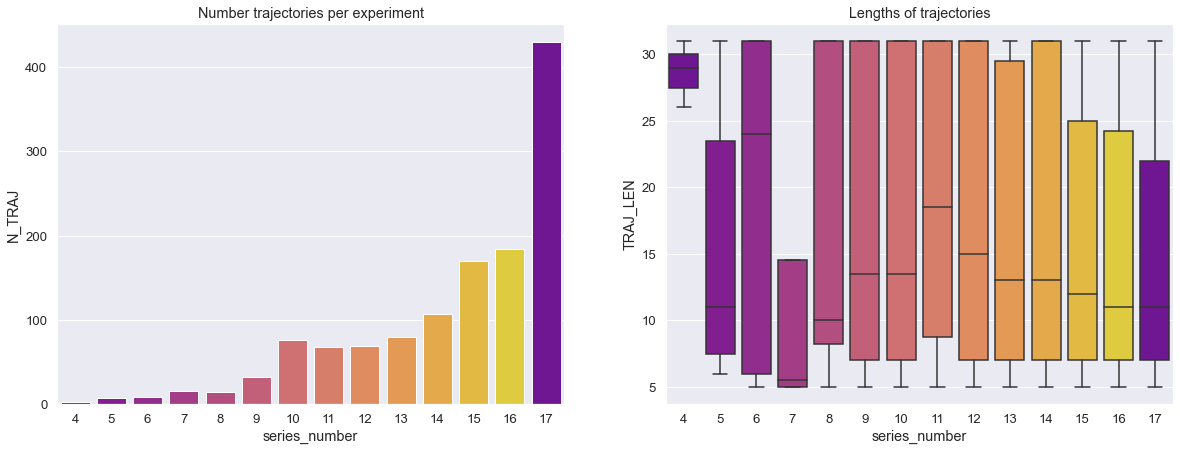

In [45]:
sns.set(font_scale=1.2)
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(20,7))
Stat_Traj_Number= TrajDescript_all.groupby(['series_number']).apply(lambda X: np.size(np.unique(X["particle"]))).reset_index(name='N_TRAJ')
sns.barplot(x="series_number",y="N_TRAJ",palette=gen_palette,data=Stat_Traj_Number,ax=ax[0])
ax[0].set_title("Number trajectories per experiment")


#Stat_Traj_Length=Data.groupby(['EXPERIMENT','REPLICA',"TRACK_ID"]).apply(len).reset_index(name="TRAJ_LEN")
sns.boxplot(x="series_number",y="TRAJ_LEN",palette=gen_palette,showfliers = False,data=TrajDescript_all,ax=ax[1])
ax[1].set_title("Lengths of trajectories");

## Compare objects movement between series
### Trajectories descriptors and measurements
To analyze trajectories we calculated set of the measurements for each trajectory.



#### trajectory global descriptors
Measurements that characterize trajectory as a whole (mapping trajectory to one number)
* **MSD** is a mean square displacement.
* **Max Distance Origin** maximum distance traveled from the trajectory origin. 
* **Length of trajectory**  number of time frames for trajectory
* **Median Area**  median area across the trajectory
* **Slope** is slope of the linear fit between Log(MSD) and Log(dt). The slope indicates character of movement. Values near 1 represents brownian type of movement, less than 1 constrained movement and bigger than 1 correspons to directed movement.

In [46]:
Select_columns=['MSD', 'MAX_DIST_ORIG', 'TRAJ_LEN', 'MEDIAN_AREA', 
       'Slope', 'series_number']

df=TrajDescript_all[Select_columns]

The graphs below represent a kernel density estimate (KDE) plot for different series. In contrast to a histogram, which that uses discrete bins to approximate the underlying probability density function, kernel density estimation (KDE) presents a different solution to the same problem. A KDE plot smooths the observations with a Gaussian kernel, producing a continuous density estimate.

We can see that KDE denisity estimates highly overlaped between different series. The KDEs overlaps imply that the character of movement does not significantly change with series time. Below are the median estimates.
* MSD median for whole data set is 18.40 pixels per 6s, so the objects spees could be estimated as 2.48 microns/s.
* MAX_DIST_ORIG median is equal 70.77 px that show that the object generally does not go further than 57 microns from the start.
* Median area of the objects is 130 px that is 85.29 micron^2
* Median of the slope is 1.16 that indicates that the character of movement are more likely superdiffusive.  

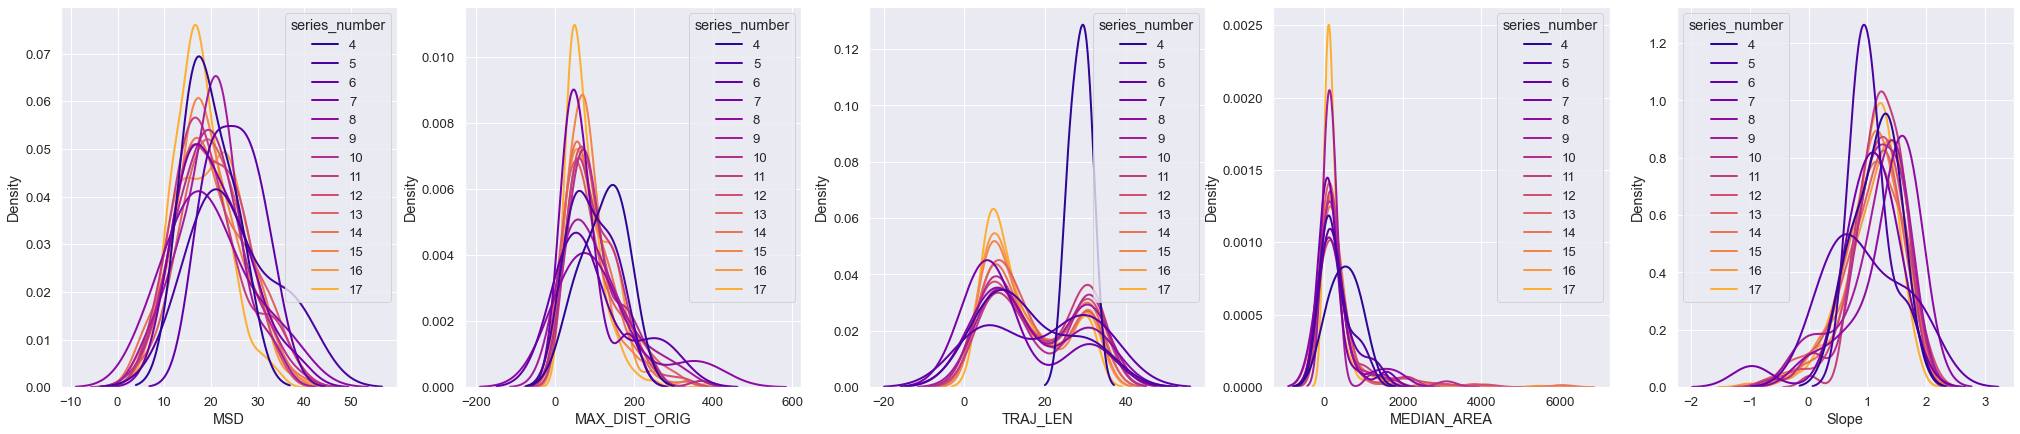

In [55]:
## small
sns.set(font_scale=1.2)
fig,ax=plt.subplots(nrows=1,ncols=5,figsize=(35,7))
axx=ax.ravel()
Select_columns
for i in range(5):
    sns.kdeplot(data=df, x=Select_columns[i], hue="series_number", bw_adjust=1.,common_norm=False,palette=gen_palette,
   alpha=.5,lw=2,ax=axx[i])

The Pairplot below shows the paired parameters scatter plots. The clouds of points are highly overlapped, that supports the hypothesis that the character of movement does not change significantly with time.

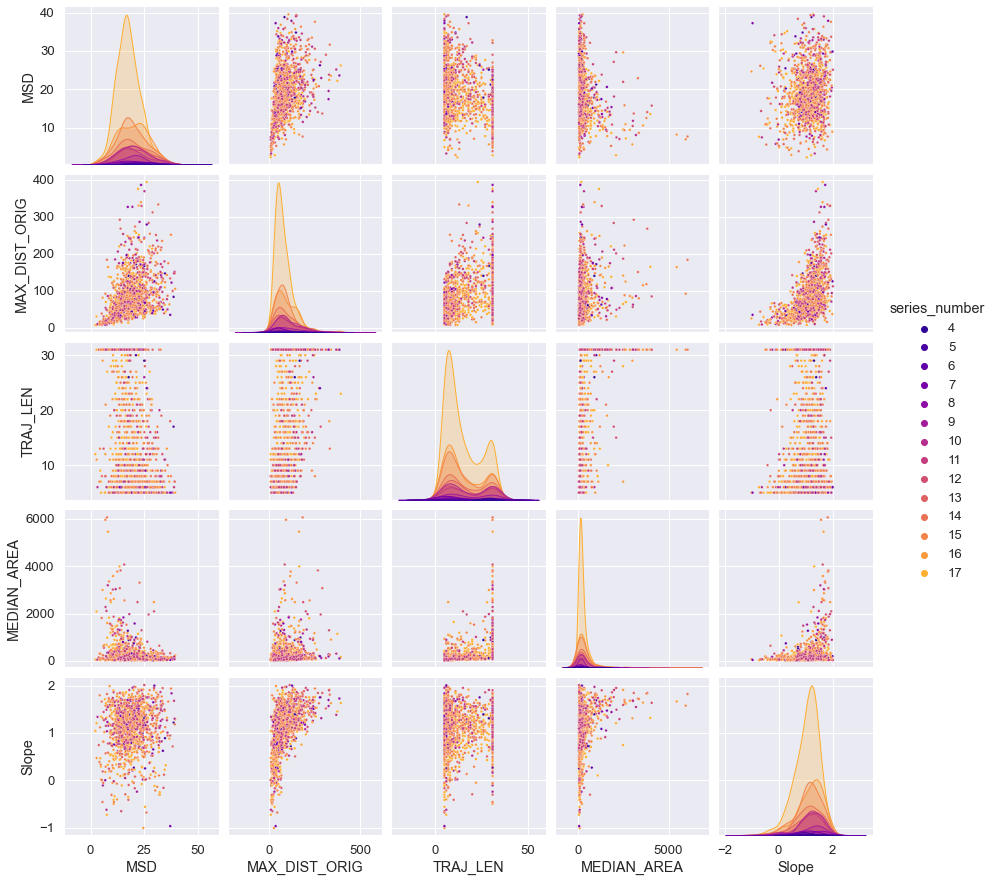

In [57]:
sns.set(font_scale=1.2)
sns.pairplot(data=df,hue='series_number',palette=gen_palette,plot_kws = {"s":7});

## Global angle

**Global Angles** Global angle is a angle between movement direction with respect to the X-axis of the fixed coordinate system.
The KDE for time series till 17 (5.6 hours) are relatively uniform, that may indicate no flow. 


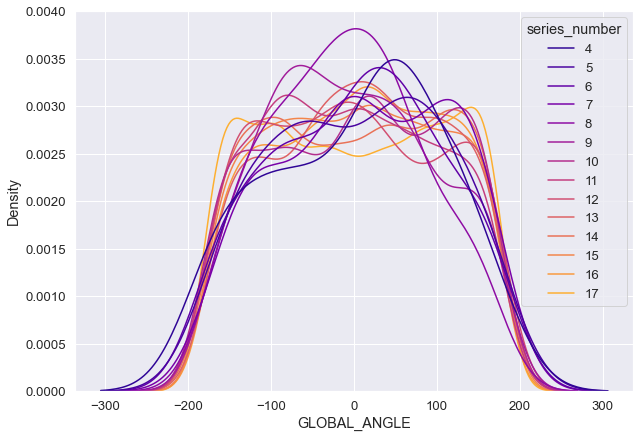

In [58]:
Df_global_angles=pd.DataFrame()
for id, group in TrajDescript_all.groupby("series_number"):
    global_angles=np.concatenate(group.GLOBAL_ANGLE)
    df_global=pd.DataFrame({"series_number":id,"GLOBAL_ANGLE":global_angles})
    Df_global_angles=pd.concat([Df_global_angles,df_global])
    
fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(10,7))
sns.kdeplot(data=Df_global_angles,x="GLOBAL_ANGLE",hue="series_number",palette=gen_palette,common_norm=False,linewidth=1.5);

## Relative angle
The relative turning angle desribes how much microcolonies movement deviates from previous directions. 
The distributions of relative turning angles are presented for different series time  on the figure below. We could see that most distribution skewed towards acute angles. So, the microcolonies prefer to persist  movement directions rather than turn.

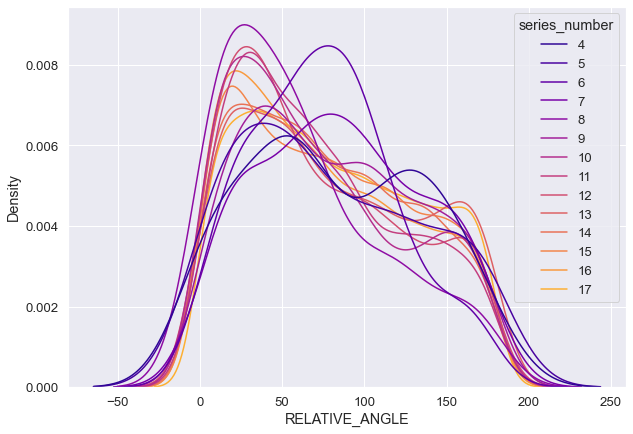

In [59]:
Df_rel_angles=pd.DataFrame()
for id, group in TrajDescript_all.groupby("series_number"):
    rel_angles=np.concatenate(group.RELATIVE_ANGLE)
    df_rel=pd.DataFrame({"series_number":id,'RELATIVE_ANGLE':rel_angles})
    Df_rel_angles=pd.concat([Df_rel_angles,df_rel])
fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(10,7))
sns.kdeplot(data=Df_rel_angles,x='RELATIVE_ANGLE',hue="series_number",palette=gen_palette,common_norm=False,linewidth=1.5);